# PART 1
# Using Resnet50 for 2 class problem in cifar10 dataset

In [10]:
import torch
import torchvision
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import ToTensor, ToPILImage

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [12]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
## Hyperparameters
batch_size = 512
lr = 8e-4     # learning rate
n_epochs = 20

In [14]:
train_dataset = CIFAR10(root='.\data', download=True, train=True, transform=ToTensor())
test_dataset = CIFAR10(root='.\data', download=True, train=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [15]:
train_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [16]:
def separate_classes(dataset,desired_labels):
  dataset_out = []
  for image,label in dataset:
    if label in desired_labels:
      dataset_out.append((image,label))
  return dataset_out

desired_labels = [0, 1]  # Plane, Car
train_dataset_d = separate_classes(train_dataset, desired_labels)
test_dataset_d = separate_classes(train_dataset, desired_labels)

In [17]:
train_dl = DataLoader(train_dataset_d, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset_d, batch_size=batch_size)

train_dl = DeviceDataLoader(train_dl,device)
test_dl = DeviceDataLoader(test_dl,device)

In [9]:
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet = to_device(resnet, device)
print(resnet.parameters)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [10]:
resnet.fc.weight

Parameter containing:
tensor([[ 0.0112,  0.0344, -0.0253,  ..., -0.0133, -0.0042,  0.0459],
        [ 0.0012,  0.0682, -0.0034,  ...,  0.0106, -0.0296,  0.0129],
        [ 0.0359, -0.0144,  0.0174,  ..., -0.0017, -0.0061,  0.0116],
        ...,
        [-0.0177,  0.1227,  0.0103,  ...,  0.0024,  0.0251, -0.0006],
        [ 0.0595, -0.1045,  0.0044,  ..., -0.0066, -0.0409, -0.0277],
        [ 0.0259,  0.0079, -0.0239,  ..., -0.0411, -0.0117,  0.0102]],
       device='cuda:0', requires_grad=True)

In [11]:
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc.weight

Parameter containing:
tensor([[ 0.0112,  0.0344, -0.0253,  ..., -0.0133, -0.0042,  0.0459],
        [ 0.0012,  0.0682, -0.0034,  ...,  0.0106, -0.0296,  0.0129],
        [ 0.0359, -0.0144,  0.0174,  ..., -0.0017, -0.0061,  0.0116],
        ...,
        [-0.0177,  0.1227,  0.0103,  ...,  0.0024,  0.0251, -0.0006],
        [ 0.0595, -0.1045,  0.0044,  ..., -0.0066, -0.0409, -0.0277],
        [ 0.0259,  0.0079, -0.0239,  ..., -0.0411, -0.0117,  0.0102]],
       device='cuda:0')

In [12]:
resnet.fc = nn.Linear(in_features=2048, out_features=2, device=device)
resnet.fc.requires_grad_=True
resnet.fc.weight

Parameter containing:
tensor([[ 0.0030, -0.0115, -0.0146,  ..., -0.0031, -0.0125, -0.0068],
        [-0.0142,  0.0002, -0.0184,  ..., -0.0112,  0.0049, -0.0189]],
       device='cuda:0', requires_grad=True)

In [13]:
for image, label in train_dl:
  out = resnet(image)
  loss = F.cross_entropy(out,label)
  break

print(loss)

tensor(0.7146, device='cuda:0', grad_fn=<NllLossBackward0>)


In [62]:
def fit_resnet(model ,train_data, lr = 1e-4, optimizer = torch.optim.Adam):
  optimizer = optimizer(model.parameters(), lr)
  for image, labels in train_data:
    out = model(image)
    loss = F.cross_entropy(out, labels)
    _, preds = torch.max(out, dim=1)
    acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  return loss, acc

def test_resnet(model,test_data):
  acc_all = []
  for image, labels in test_data:
    out = model(image)
    _, preds = torch.max(out, dim=1)
    acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
    acc_all.append(acc.item())
  return acc_all

In [15]:
loss_overall, acc_overall = [], []
for e in range(n_epochs):
  loss, acc = fit_resnet(model=resnet ,train_data=train_dl, lr=lr)
  loss_overall.append(loss.item())
  acc_overall.append(acc.item())
  print('Epoch:',e,'loss',loss.item(),'accuracy:',acc.item())

Epoch: 0 loss 0.5404449701309204 accuracy: 0.7683823704719543
Epoch: 1 loss 0.4246003031730652 accuracy: 0.8639705777168274
Epoch: 2 loss 0.37113282084465027 accuracy: 0.8676470518112183
Epoch: 3 loss 0.30621132254600525 accuracy: 0.8897058963775635
Epoch: 4 loss 0.3412630558013916 accuracy: 0.8345588445663452
Epoch: 5 loss 0.34947922825813293 accuracy: 0.8786764740943909
Epoch: 6 loss 0.3457784950733185 accuracy: 0.8345588445663452
Epoch: 7 loss 0.32703983783721924 accuracy: 0.8786764740943909
Epoch: 8 loss 0.407387375831604 accuracy: 0.845588207244873
Epoch: 9 loss 0.39434513449668884 accuracy: 0.8088235259056091
Epoch: 10 loss 0.3781884014606476 accuracy: 0.8676470518112183
Epoch: 11 loss 0.3584047257900238 accuracy: 0.8529411554336548
Epoch: 12 loss 0.288568377494812 accuracy: 0.8713235259056091
Epoch: 13 loss 0.28727638721466064 accuracy: 0.8860294222831726
Epoch: 14 loss 0.35949456691741943 accuracy: 0.8492646813392639
Epoch: 15 loss 0.3664829730987549 accuracy: 0.849264681339263

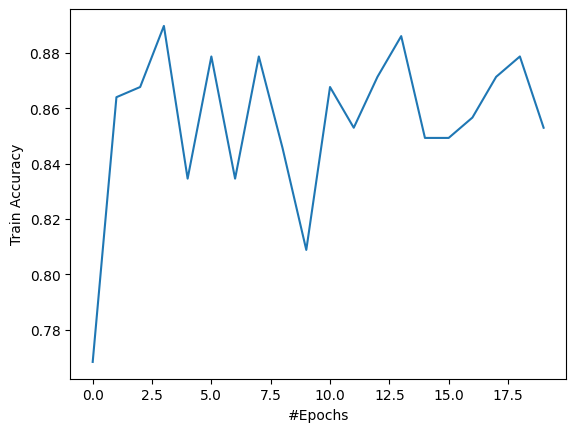

In [16]:
epoch_vec = np.arange(0,n_epochs)
plt.plot(epoch_vec,acc_overall)
plt.xlabel('#Epochs')
plt.ylabel('Train Accuracy')
plt.show()

In [17]:
acc_test = test_resnet(resnet,test_dl)
print('mean test accuracy:',np.mean(acc_test))
print('variance of test accuracy:',np.var(acc_test))

mean test accuracy: 0.8839096963405609
variance of test accuracy: 0.00019969542036687218


# Part 2
# triplet loss

In [18]:
## Hyperparameters
batch_size = 512
lr = 8e-4     # learning rate
n_epochs = 20

In [43]:
class CIFAR10_new(Dataset):
    def __init__(self, dataset, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()

        self.images = []
        self.labels = []
        if self.is_train:
            for image,label in dataset:
                self.images.append(image)
                self.labels.append(label)
        else:
            for image,label in dataset:
                self.images.append(image)
                # self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        anchor_img = self.images[item]

        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = [self.images[i] for i in range(len(self.labels)) if self.labels[i]==anchor_label and i!=item]
            positive_img = random.choice(positive_list)

            negative_list = [self.images[i] for i in range(len(self.labels)) if self.labels[i]!=anchor_label and i!=item]
            negative_img = random.choice(negative_list)

            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))

            return anchor_img, positive_img, negative_img, anchor_label

        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img


In [44]:
train_ds_tripleLoss = CIFAR10_new(train_dataset_d, train=True, transform=ToTensor())
# test_ds = CIFAR10_new(test_dataset_d, train=False, transform=ToTensor())

train_dl_tripleLoss = DataLoader(train_ds_tripleLoss, batch_size=batch_size, shuffle=True)
train_dl_tripleLoss = DeviceDataLoader(train_dl_tripleLoss, device)

# test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)
# test_dl = DeviceDataLoader(test_dl, device)

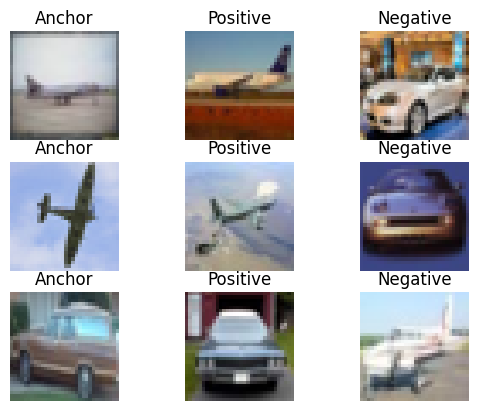

In [21]:
k = 0
nk = 3
for anchor,positive,negative,label in train_dl_tripleLoss:
    plt.subplot(nk,3,3*k+1)
    plt.imshow(anchor[0].permute((1,2,0)).to('cpu'))
    plt.title('Anchor')
    plt.axis('off')
    plt.subplot(nk,3,3*k+2)
    plt.imshow(positive[0].permute(1,2,0).to('cpu'))
    plt.title('Positive')
    plt.axis('off')
    plt.subplot(nk,3,3*k+3)
    plt.imshow(negative[0].permute(1,2,0).to('cpu'))
    plt.title('Negative')
    plt.axis('off')
    k += 1
    if k==nk:
        break

In [39]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def euc_dist(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def forward(self, anchor, positive, negative):
        distance_positive = self.euc_dist(anchor, positive)
        distance_negative = self.euc_dist(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        loss_out = losses.mean()
        return loss_out

In [23]:
resnet_tripleLoss_conv = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet_tripleLoss_conv = torch.nn.Sequential(*(list(resnet_tripleLoss_conv.children())[:-1]))
resnet_tripleLoss = to_device(resnet_tripleLoss_conv, device)


In [24]:
def fit_resnet_new(model ,train_data, lr = 1e-4, optimizer = torch.optim.Adam):
  optimizer = optimizer(model.parameters(), lr)
  loss_fn = TripletLoss()
  for anchor_img, positive_img, negative_img, label in train_data:
    out_anchor = resnet_tripleLoss(anchor_img)
    out_positive = resnet_tripleLoss(positive_img)
    out_negative = resnet_tripleLoss(negative_img)
    # print(out_positive.shape)
    loss = loss_fn.forward(anchor=torch.squeeze(out_anchor), positive=torch.squeeze(out_positive), negative=torch.squeeze(out_negative))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  return loss

In [25]:
loss_overall = []
for e in range(n_epochs):
  loss = fit_resnet_new(model=resnet_tripleLoss ,train_data=train_dl_tripleLoss, lr=lr)
  loss_overall.append(loss.item())
  print('Epoch:',e,'train loss:',loss.item())

Epoch: 0 train loss: 159.5994415283203
Epoch: 1 train loss: 166.22842407226562
Epoch: 2 train loss: 134.49301147460938
Epoch: 3 train loss: 97.92955780029297
Epoch: 4 train loss: 92.10778045654297
Epoch: 5 train loss: 23.351335525512695
Epoch: 6 train loss: 15.788240432739258
Epoch: 7 train loss: 5.513695240020752
Epoch: 8 train loss: 0.495053231716156
Epoch: 9 train loss: 0.9078854322433472
Epoch: 10 train loss: 1020.9618530273438
Epoch: 11 train loss: 8.68105697631836
Epoch: 12 train loss: 0.513453483581543
Epoch: 13 train loss: 0.2727004289627075
Epoch: 14 train loss: 0.6251177191734314
Epoch: 15 train loss: 0.3105045258998871
Epoch: 16 train loss: 0.004559841938316822
Epoch: 17 train loss: 0.2971703112125397
Epoch: 18 train loss: 0.1155058741569519
Epoch: 19 train loss: 0.3047052323818207


In [36]:
class resnet_tripleLoss(nn.Module):
    def __init__(self, resnet_tripleLoss_conv):
        super(resnet_tripleLoss, self).__init__()
        self.features = nn.Sequential(*(list(resnet_tripleLoss_conv.children())[:-1]))
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 2, bias=True)

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model_end = resnet_tripleLoss(resnet_tripleLoss_conv)

In [37]:
for param in model_end.parameters():
    param.requires_grad = False
model_end.fc = nn.Linear(2048, 2, bias=True, device=device)
model_end = to_device(model_end,device)

In [38]:
loss_overall, acc_overall = [], []
for e in range(n_epochs):
  loss, acc = fit_resnet(model=model_end ,train_data=train_dl, lr=lr)
  loss_overall.append(loss.item())
  acc_overall.append(acc.item())
  print('Epoch:',e,'loss',loss.item(),'accuracy:',acc.item())

Epoch: 0 loss 0.6584591865539551 accuracy: 0.9007353186607361
Epoch: 1 loss 0.6165857315063477 accuracy: 0.9264705777168274
Epoch: 2 loss 0.6268126368522644 accuracy: 0.9411764740943909
Epoch: 3 loss 0.5216063857078552 accuracy: 0.9264705777168274
Epoch: 4 loss 0.6028020977973938 accuracy: 0.9007353186607361
Epoch: 5 loss 0.4806666076183319 accuracy: 0.9448529481887817
Epoch: 6 loss 0.5203560590744019 accuracy: 0.9411764740943909
Epoch: 7 loss 0.5269882082939148 accuracy: 0.9522058963775635
Epoch: 8 loss 0.544579029083252 accuracy: 0.9154411554336548
Epoch: 9 loss 0.39171934127807617 accuracy: 0.9264705777168274
Epoch: 10 loss 0.3969523310661316 accuracy: 0.9301470518112183
Epoch: 11 loss 0.50015789270401 accuracy: 0.8933823704719543
Epoch: 12 loss 0.35711219906806946 accuracy: 0.904411792755127
Epoch: 13 loss 0.4740750789642334 accuracy: 0.9301470518112183
Epoch: 14 loss 0.48191890120506287 accuracy: 0.875
Epoch: 15 loss 0.41300976276397705 accuracy: 0.908088207244873
Epoch: 16 loss 0

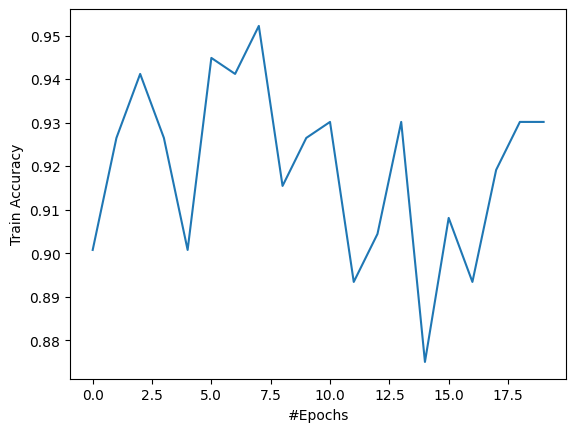

In [39]:
epoch_vec = np.arange(0,n_epochs)
plt.plot(epoch_vec,acc_overall)
plt.xlabel('#Epochs')
plt.ylabel('Train Accuracy')
plt.show()

In [40]:
acc_test = test_resnet(model_end,test_dl)
print('mean test accuracy:',np.mean(acc_test))
print('variance of test accuracy:',np.var(acc_test))

mean test accuracy: 0.9240808814764023
variance of test accuracy: 0.00014314302568773306


# Part 3

In [74]:
## Hyperparameters
batch_size = 512
lr = 8e-4     # learning rate
n_epochs = 6

In [75]:
resnet_tripleLoss_conv = resnet50(weights=ResNet50_Weights.DEFAULT)

class resnet_tripleLoss(nn.Module):
    def __init__(self):
        super(resnet_tripleLoss, self).__init__()
        self.features = nn.Sequential(*(list(resnet_tripleLoss_conv.children())[:-1]))
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 2, bias=True)

    def forward(self, x):
        out1 = self.features(x)
        out2 = self.avg_pool(out1)
        out2 = torch.flatten(out2, 1)
        out2 = self.fc(out2)
        return out1, out2

model = resnet_tripleLoss()

In [76]:
def fit_resnet_new(model ,train_data, lr = 1e-4, optimizer = torch.optim.Adam):
  optimizer = optimizer(model.parameters(), lr)
  loss_fn = TripletLoss()
  for anchor_img, positive_img, negative_img, label in train_data:
    out_anchor,out2_anchor = model(anchor_img)
    out_positive,_ = model(positive_img)
    out_negative,_ = model(negative_img)

    loss1 = loss_fn.forward(anchor=torch.squeeze(out_anchor), positive=torch.squeeze(out_positive), negative=torch.squeeze(out_negative))
    loss2 = F.cross_entropy(out2_anchor, label)
    _, preds = torch.max(out2_anchor, dim=1)
    acc = torch.tensor(torch.sum(preds == label).item() / len(preds))
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  return loss, acc

def test_resnet_new(model,test_data):
  acc_all = []
  for image, labels in test_data:
    _,out = model(image)
    _, preds = torch.max(out, dim=1)
    acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
    acc_all.append(acc.item())
  return acc_all

In [77]:
loss_overall, acc_overall = [], []
for e in range(n_epochs):
  loss, acc = fit_resnet_new(model=model ,train_data=train_dl_tripleLoss, lr=lr)
  loss_overall.append(loss.item())
  acc_overall.append(acc.item())
  print('Epoch:',e,'loss',loss.item(),'accuracy:',acc.item())

Epoch: 0 loss 3.054379463195801 accuracy: 0.591911792755127
Epoch: 1 loss 1.68119215965271 accuracy: 0.5147058963775635
Epoch: 2 loss 1.8114209175109863 accuracy: 0.720588207244873
Epoch: 3 loss 1.2991821765899658 accuracy: 0.8382353186607361
Epoch: 4 loss 0.9452962875366211 accuracy: 0.9338235259056091
Epoch: 5 loss 0.7729721665382385 accuracy: 0.9779411554336548


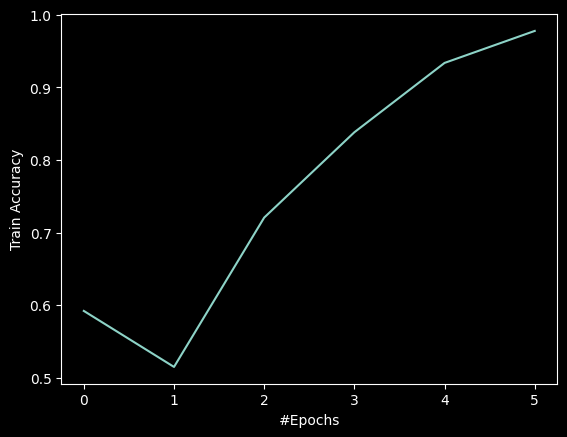

In [78]:
epoch_vec = np.arange(0,n_epochs)
plt.plot(epoch_vec,acc_overall)
plt.xlabel('#Epochs')
plt.ylabel('Train Accuracy')
plt.show()

In [79]:
acc_test = test_resnet_new(model,test_dl)
print('mean test accuracy:',np.mean(acc_test))
print('variance of test accuracy:',np.var(acc_test))

mean test accuracy: 0.9339499086141586
variance of test accuracy: 0.00022617579215032714
